# Otimização em Redes Ad Hoc usando Algoritmo Genético (com Latência)
Este notebook aplica um Algoritmo Genético (GA) para encontrar uma rota de baixa latência em uma rede ad hoc representada por um grafo direcionado. O objetivo é minimizar a latência total da comunicação entre um nó de origem e um nó de destino, respeitando as capacidades máximas dos enlaces. Essa abordagem considera operadores genéticos (crossover, mutação) e penaliza soluções que ultrapassem os limites de capacidade.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install networkx matplotlib numpy

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import random
import numpy as np

In [ ]:
import networkx as nx
import json

# Definição dos nós
nodes = {
    0: {"label": "FOB Alpha"},
    1: {"label": "FOB Bravo"},
    2: {"label": "Drone 1"},
    3: {"label": "Drone 2"},
    4: {"label": "Unidade Móvel A"},
    5: {"label": "Unidade Móvel B"},
    6: {"label": "Unidade Móvel C"},
    7: {"label": "Posto de Comunicação 1"},
    8: {"label": "Posto de Comunicação 2"},
    9: {"label": "Centro de Comando Regional"}
}

# Arestas com custo simulando latência base + capacidade
edges = [
    (0, 4, {"cost": 3, "capacity": 10}),
    (1, 5, {"cost": 4, "capacity": 10}),
    (4, 2, {"cost": 2, "capacity": 8}),
    (5, 2, {"cost": 3, "capacity": 8}),
    (2, 7, {"cost": 5, "capacity": 12}),
    (3, 8, {"cost": 4, "capacity": 12}),
    (4, 3, {"cost": 6, "capacity": 6}),
    (5, 3, {"cost": 5, "capacity": 6}),
    (7, 9, {"cost": 2, "capacity": 15}),
    (8, 9, {"cost": 2, "capacity": 15}),
    (6, 2, {"cost": 4, "capacity": 7}),
    (6, 3, {"cost": 4, "capacity": 7}),
    (0, 6, {"cost": 6, "capacity": 5}),
    (1, 6, {"cost": 5, "capacity": 5}),
    (6, 7, {"cost": 3, "capacity": 8}),
    (6, 8, {"cost": 3, "capacity": 8}),
]

# Layout fixo
pos = {
    0: (0, 0),
    1: (0, -2),
    4: (2, 0.5),
    5: (2, -1.5),
    6: (2, -0.5),
    2: (4, 1),
    3: (4, -1),
    7: (6, 1),
    8: (6, -1),
    9: (8, 0)
}

# Criar grafo e adicionar elementos
G = nx.DiGraph()
for n, attr in nodes.items():
    G.add_node(n, **attr)
G.add_edges_from(edges)

# Exportar estrutura como JSON
graph_data = {
    "nodes": nodes,
    "edges": [(u, v, d) for u, v, d in G.edges(data=True)],
    "pos": pos
}

# Salvar no ambiente do Colab
with open("rede_afeganistao.json", "w", encoding="utf-8") as f:
    json.dump(graph_data, f)

print("Arquivo 'rede_afeganistao.json' gerado com sucesso.")


Arquivo 'rede_afeganistao.json' gerado com sucesso.


## Carregando a Rede com Latências

In [ ]:
# Carregar estrutura da rede
with open('rede_afeganistao.json', 'r') as f:
    data = json.load(f)

G = nx.DiGraph()
for n, attr in data['nodes'].items():
    G.add_node(int(n), **attr)
for u, v, d in data['edges']:
    # Substituir custo por latência fictícia (simulada aleatoriamente)
    d['latency'] = d['cost'] + random.randint(0, 3)
    G.add_edge(u, v, **d)
pos = {int(k): tuple(v) for k, v in data['pos'].items()}

## Visualização da Rede

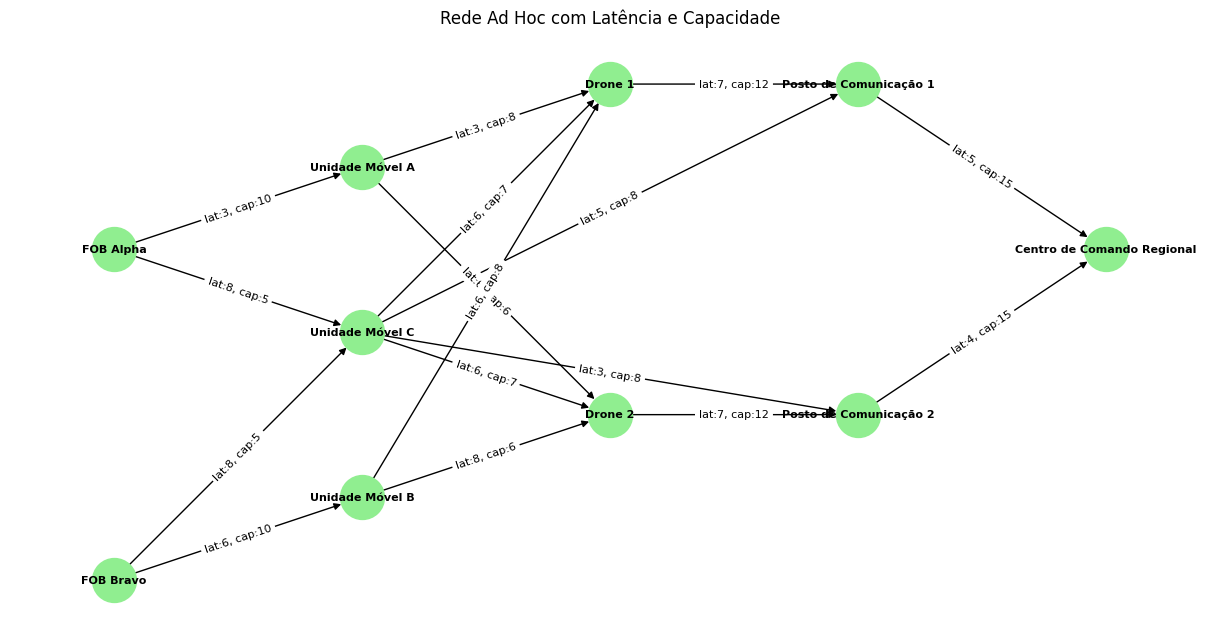

In [ ]:
plt.figure(figsize=(12, 6))
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_color='lightgreen', node_size=1000, font_size=8, font_weight='bold')
edge_labels = {(u, v): f"lat:{d['latency']}, cap:{d['capacity']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Rede Ad Hoc com Latência e Capacidade")
plt.axis('off')
plt.show()

## Definição do Problema

In [ ]:
source, sink = 0, 9
demand = 10

## Funções Auxiliares para Avaliação e Mutação

In [ ]:
def generate_path(graph, source, sink):
    try:
        return nx.shortest_path(graph, source, sink)
    except:
        return []

def path_latency(graph, path):
    return sum(graph[path[i]][path[i+1]]['latency'] for i in range(len(path)-1))

def violates_capacity(graph, path, demand):
    for i in range(len(path)-1):
        u, v = path[i], path[i+1]
        if graph[u][v]['capacity'] < demand:
            return True
    return False

def mutate_path(graph, path):
    if len(path) > 3:
        new_target = path[random.randint(1, len(path)-2)]
        try:
            subpath1 = nx.shortest_path(graph, source, new_target)
            subpath2 = nx.shortest_path(graph, new_target, sink)
            return subpath1[:-1] + subpath2
        except:
            return path
    return path

## Execução do Algoritmo Genético com Penalização

In [ ]:
POP_SIZE = 30
N_GENERATIONS = 50
MUTATION_RATE = 0.3
population = [generate_path(G, source, sink) for _ in range(POP_SIZE)]
population = [p for p in population if len(p) > 1]

def fitness(graph, path):
    if not path or violates_capacity(graph, path, demand):
        return float('inf')
    return path_latency(graph, path)

def evaluate(pop):
    return sorted(pop, key=lambda p: fitness(G, p))

for generation in range(N_GENERATIONS):
    population = evaluate(population)[:POP_SIZE]
    next_gen = population[:5]
    while len(next_gen) < POP_SIZE:
        p1, p2 = random.sample(population, 2)
        common = list(set(p1) & set(p2) - {source, sink})
        if common:
            split = random.choice(common)
            i1 = p1.index(split)
            i2 = p2.index(split)
            child = p1[:i1] + p2[i2:]
        else:
            child = generate_path(G, source, sink)
        if random.random() < MUTATION_RATE:
            child = mutate_path(G, child)
        if child and len(child) > 1:
            next_gen.append(child)
    population = next_gen

best_path = evaluate(population)[0]
print("Melhor caminho:", best_path)
print("Latência total:", path_latency(G, best_path))

Melhor caminho: [0, 6, 7, 9]
Latência total: 18


## Visualização do Melhor Caminho com Menor Latência

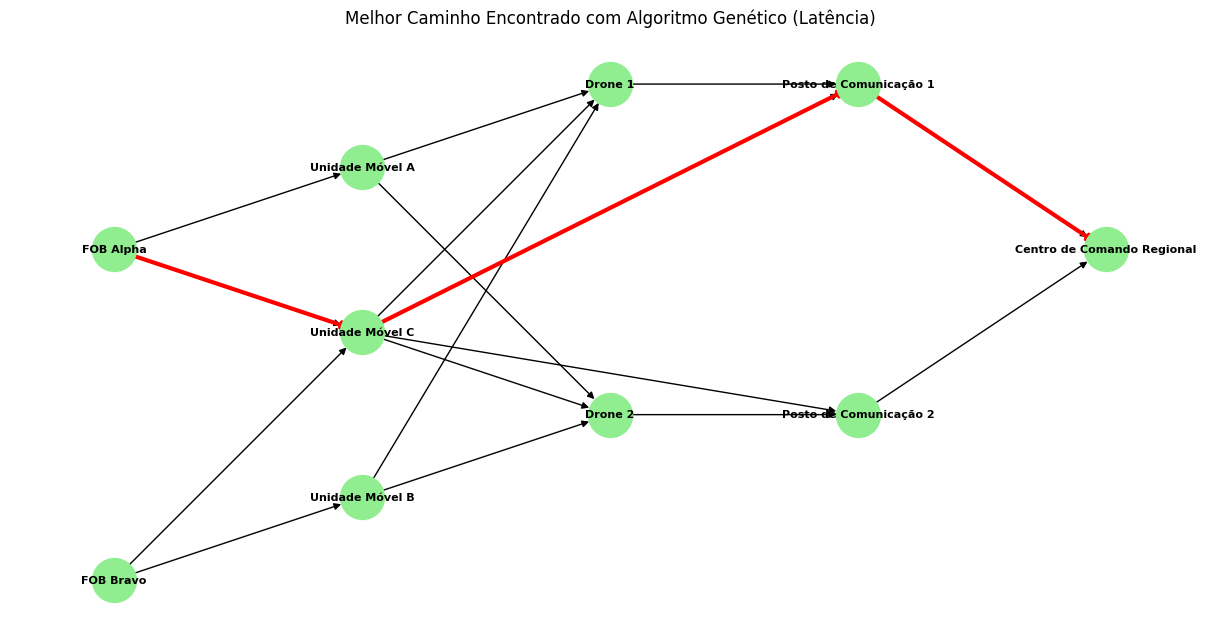

In [ ]:
plt.figure(figsize=(12, 6))
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_color='lightgreen', node_size=1000, font_size=8, font_weight='bold')
path_edges = [(best_path[i], best_path[i+1]) for i in range(len(best_path)-1)]
nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=3, edge_color='red')
plt.title("Melhor Caminho Encontrado com Algoritmo Genético (Latência)")
plt.axis('off')
plt.show()